# Expectation Propagation

ForneyLab comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation with a SSM that incorporates a gaussian state-evolution model, but a discrete observation model. Here, the sigmoid function constrains the continuous variable `x_t` with the discrete variable `y_t`. 

\begin{align*}
    u &= 0.2\\
    x_t &= x_{t-1} + u\\
    y_t &\sim \mathcal{B}er(\sigma(x_t))
\end{align*}

The factor graph below shows one section of the generative model.

```
              (u)
               |
               v
(x_t_min) ---> + ---> = ---> (x_t)
                      |
                     [σ]
                      | 
                    (y_t)
```

In [1]:
using SpecialFunctions

# Toy dataset
n_samples = 40

u_data = 0.05
x_data = [u_data*t - 1.0 for t=1:n_samples] # State
y_data = (2*rand(n_samples) - 1 .< erf.(x_data)); # Observations

# Build

In [2]:
using ForneyLab

g = FactorGraph()

# Prior statistics
m_x_0 = Variable(id=:m_x_0)
v_x_0 = Variable(id=:v_x_0)

# State prior
@RV x_0 ~ GaussianMeanVariance(m_x_0, v_x_0)

x = Vector{Variable}(n_samples)
y = Vector{Variable}(n_samples)
x_t_min = x_0
for t = 1:n_samples
    u_t = constant(u_data)
    x[t] = x_t_min + u_t
    y[t] = Variable(id=:y_*t)
    Sigmoid(y[t], x[t])

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end

# Placeholders for prior statistics
placeholder(m_x_0, :m_x_0)
placeholder(v_x_0, :v_x_0)

# Name state variables for ease of lookup
for t = 1:n_samples
    x[t].id = :x_*t
end

# Schedule

With the model defined, we can now generate an EP algorithm. The EP algorithm requires message initializations. We can initialize the messages through the `messages` argument of the `step!()` function. The `init()` function automatically generates an initial message vector for us.

In [3]:
algo = expectationPropagationAlgorithm(x)

println(algo)

function init()

messages = Array{Message}(237)
messages[163] = Message(vague(Gaussian))
messages[145] = Message(vague(Gaussian))
messages[119] = Message(vague(Gaussian))
messages[229] = Message(vague(Gaussian))
messages[166] = Message(vague(Gaussian))
messages[201] = Message(vague(Gaussian))
messages[228] = Message(vague(Gaussian))
messages[197] = Message(vague(Gaussian))
messages[234] = Message(vague(Gaussian))
messages[207] = Message(vague(Gaussian))
messages[210] = Message(vague(Gaussian))
messages[236] = Message(vague(Gaussian))
messages[235] = Message(vague(Gaussian))
messages[179] = Message(vague(Gaussian))
messages[232] = Message(vague(Gaussian))
messages[225] = Message(vague(Gaussian))
messages[219] = Message(vague(Gaussian))
messages[204] = Message(vague(Gaussian))
messages[185] = Message(vague(Gaussian))
messages[182] = Message(vague(Gaussian))
messages[176] = Message(vague(Gaussian))
messages[222] = Message(vague(Gaussian))
messages[148] = Message(vague(Gaussian))
messages[

# Infer

In [4]:
eval(parse("begin\n"*algo*"\nend")) # parse for multiple statements must be wrapped in block

messages = init()
marginals = Dict()
data = Dict(:y => y_data,
            :m_x_0 => 0.0,
            :v_x_0 => 10.0)

n_its = 2*n_samples
for i = 1:n_its
   step!(data, marginals, messages)
end

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples];

# Results

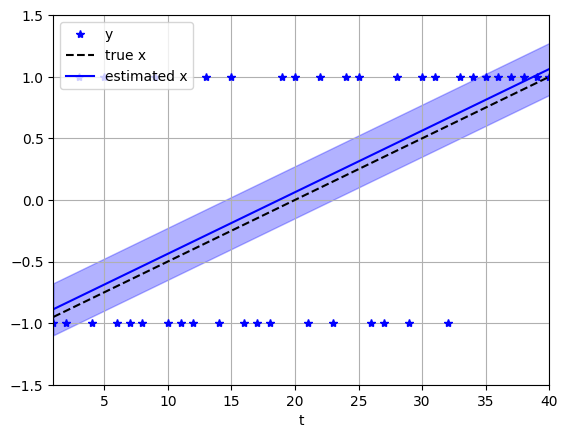

In [5]:
using PyPlot

plot(collect(1:n_samples), 2*y_data - 1, "b*", label="y")
plot(collect(1:n_samples), x_data, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
xlim(1, n_samples)
ylim(-1.5, 1.5)
legend(loc="upper left");